In [1]:
# These two lines allow for the notebook to automatically update to use the most
# up-to-date versions of the code being imported
%load_ext autoreload
%autoreload 2

# General important stuff
import sys
sys.path.append('..')

import control as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from control_systems.control_core import *
from control_systems.calculate_laser_noise import *

# plt.style.available
%matplotlib inline
plt.style.use('science')
plt.rcParams['figure.figsize'] = [4,3]

In [2]:
Pin = 1e-4 # input power 0.1mW
dv = 30e6  # cavity linewidth 30MHz
NEP = 4e-12# PD NEP 4pW/rtHz
S_sh = get_S_shot(Pin, dv)
S_pd = get_S_PD(NEP, Pin, dv) # [Hz^2/Hz]
S_pd

0.22499999999999992

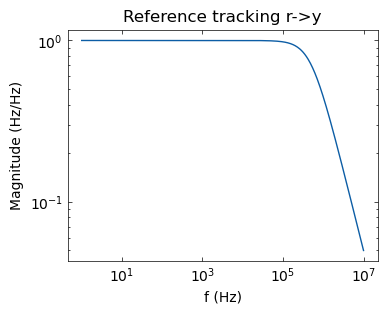

In [7]:
freq_points = 500
s = ct.tf('s')
sys = 10e6/(1 + s/(2*np.pi*1e5))
laser = ControlModule(freq_points = freq_points, sys_ref = sys, unit_in = 'V', unit_out = 'Hz', label = 'laser')
df = pd.read_csv('laserdata/ML_FN_data.csv')
FN = df.values
FNx = S_noise_interp(FN[:,0],FN[:,1],laser.freqx)
laser.output_noise = FNx

sys = 1 + 2*np.pi*1e5/s
servo = ControlModule(freq_points = freq_points, sys_ref = sys, unit_in = 'V', unit_out = 'V', label = 'servo')
servo.output_noise = np.ones(freq_points)*1e-12

Dv = 0.5e-6 # error discrimination Dv = 0.5V/MHz [V/Hz]
sys = Dv
disc = ControlModule(freq_points = freq_points, sys_ref = sys, unit_in = 'Hz', unit_out = 'V', label = 'freq disc')
disc.output_noise = np.ones(len(disc.freqx))*S_pd*Dv**2

C_list = [disc, servo, laser]
pdh = feedback_combine(C_list, 2)
pdh.input_noise = get_S_TRN(laser.freqx)
pdh.freqresp_module_update()

pdh.plot_ref_tracking()

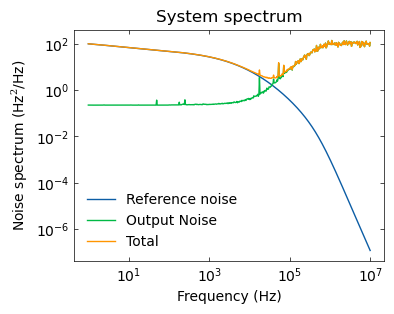

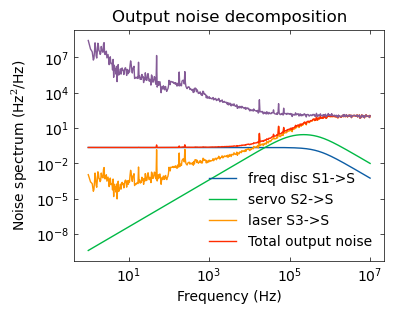

In [9]:
pdh.plot_module_noise()
plt.loglog(laser.freqx,laser.output_noise)